## Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
# import torch.nn as nn
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchvision import transforms, datasets

from tqdm import tqdm

## 設定

In [3]:
ID = 'rowID'
TARGET = 'Objective Variable_CL(L/hr/kg)'
TARGET_LOG = 'Objective Variable_CL(L/hr/kg)_Log'

TRAIN_PATH = '../data/train_fps.csv'
TEST_PATH = '../data/test_fps.csv'

# BATCH_SIZE= 460

## データ用意

In [4]:
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)
df_train.rename(columns={TARGET: 'y', TARGET_LOG: 'logy', ID:'ID'}, inplace=True)
df_test.rename(columns={ID:'ID'}, inplace=True)

X = df_train.drop(['ID', 'y', 'logy'], axis=1)
y = df_train.logy
print(X.shape, y.shape)

(1379, 2048) (1379,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.5, shuffle=True, random_state=1)

inps_train = torch.from_numpy(X_train.astype('float').values)
tgts_train = torch.from_numpy(y_train.values).view(-1, 1)
inps_test = torch.from_numpy(X_test.astype('float').values)
tgts_test = torch.from_numpy(y_test.values).view(-1, 1)

In [6]:
inps_train.size(), tgts_train.size(), inps_test.size(), tgts_test.size()

(torch.Size([689, 2048]),
 torch.Size([689, 1]),
 torch.Size([690, 2048]),
 torch.Size([690, 1]))

## モデル用意

In [28]:
class VeryBasicNet(nn.Module):
    def __init__(self, input_features, output_neurons):
        super().__init__()
        self.fc = nn.Linear(input_features, output_neurons)
        
    def forward(self, X):
        return self.fc(X)

### ハイパラ設定

In [7]:
INPUT_FEATURES = inps_train.size()[1]
OUTPUT_NEURONS = tgts_train.size()[1]

N_EPOCH = 1000
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [45]:
model = VeryBasicNet(INPUT_FEATURES, OUTPUT_NEURONS)
loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.03)

for epoch in range(N_EPOCH):
    
    inputs = inps_train.float().to(DEVICE)
    targets = tgts_train.float().to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_func(outputs, targets)
    loss.backward()

    optimizer.step()

    if epoch % 100 == 99:
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(loss.item()):.4f}')

print('Finish training')


model.eval()
with torch.no_grad():
    inputs = inps_test.float().to(DEVICE)
    targets = tgts_test.float().to(DEVICE)          
    outputs = model(inputs)

    loss = loss_func(outputs, targets)

print(f"Validation loss:{np.sqrt(loss.item()):.4f}")

Epoch: [100/1000], Loss: 0.0254
Epoch: [200/1000], Loss: 0.0120
Epoch: [300/1000], Loss: 0.0116
Epoch: [400/1000], Loss: 0.0116
Epoch: [500/1000], Loss: 0.0116
Epoch: [600/1000], Loss: 0.0116
Epoch: [700/1000], Loss: 0.0116
Epoch: [800/1000], Loss: 0.0116
Epoch: [900/1000], Loss: 0.0116
Epoch: [1000/1000], Loss: 0.0116
Finish training
Validation loss:0.7939


## Deepにする

In [47]:
MIDDLE_LAYER = 300

class BasicNet(nn.Module):
    def __init__(self, input_features, output_neurons):
        super().__init__()
        self.fc1 = nn.Linear(input_features, MIDDLE_LAYER)
        self.fc2 = nn.Linear(MIDDLE_LAYER, output_neurons)
        
    def forward(self, X):
        X = self.fc1(X).clamp(min=0)
        X = self.fc2(X)
        return X

In [48]:
INPUT_FEATURES = inps_train.size()[1]
OUTPUT_NEURONS = tgts_train.size()[1]

N_EPOCH = 1000
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [50]:
model = BasicNet(INPUT_FEATURES, OUTPUT_NEURONS)
loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.03)

for epoch in range(N_EPOCH):
    
    inputs = inps_train.float().to(DEVICE)
    targets = tgts_train.float().to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_func(outputs, targets)
    loss.backward()

    optimizer.step()

    if epoch % 100 == 99:
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(loss.item()):.4f}')

print('Finish training')


model.eval()
with torch.no_grad():
    inputs = inps_test.float().to(DEVICE)
    targets = tgts_test.float().to(DEVICE)          
    outputs = model(inputs)

    loss = loss_func(outputs, targets)

print(f"Validation loss:{np.sqrt(loss.item()):.4f}")

Epoch: [100/1000], Loss: 0.7281
Epoch: [200/1000], Loss: 0.7149
Epoch: [300/1000], Loss: 0.7149
Epoch: [400/1000], Loss: 0.7149
Epoch: [500/1000], Loss: 0.7149
Epoch: [600/1000], Loss: 0.7149
Epoch: [700/1000], Loss: 0.7149
Epoch: [800/1000], Loss: 0.7149
Epoch: [900/1000], Loss: 0.7149
Epoch: [1000/1000], Loss: 0.7149
Finish training
Validation loss:0.6654


## Conv

In [185]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        # 大きさ変わらないConv　出力の次元が増える
        self.conv1 = nn.Conv1d(1, 2, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv1d(2, 4, kernel_size=5, stride=2, padding=2)
        # 半分のサイズになるpooling
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(4 * 128, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)
        
        
    def forward(self, X):
        X = X.view(-1, 1, X.size()[1])
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        # viewはreshapeと同じ
        X = X.view(-1, 4 * 128)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        return self.fc3(X)

In [186]:
# INPUT_FEATURES = X.shape[1]
# OUTPUT_NEURONS = 1

N_EPOCH = 1000
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [187]:
# 特徴量の数が不明でもConvから入れば問題ない

# ここのConvのchannel数は、考えないといけなさそう
# LAYERS = [10, 20, 40, 80]
# OUT_DIM = 1

max_lr = 0.00025
base_lr = 0.00004

model = BasicCNN()

loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=base_lr)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=4, cycle_momentum=False)

In [188]:
lr_history = []
val_loss_history = []
trn_loss_history = []

def validate():
    model.eval()
    with torch.no_grad():
        inputs = inps_test.float().to(DEVICE)
        targets = tgts_test.float().to(DEVICE)          
        outputs = model(inputs)

        loss = loss_func(outputs, targets)
    return loss.item()

for epoch in range(N_EPOCH):
    model.train()
    
    inputs = inps_train.float().to(DEVICE)
    targets = tgts_train.float().to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_func(outputs, targets)
    loss.backward()

    optimizer.step()
    
    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_history.append(lr_step)
    scheduler.step()
    
    trn_loss_history.append(loss.item())
    val_loss = validate()
    val_loss_history.append(val_loss)

    if epoch % 100 == 99:        
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(loss.item()):.4f}, Validation loss:{np.sqrt(val_loss):.4f}')

print('Finish training')


# print(f"Validation loss:{np.sqrt(loss.item()):.4f}")

Epoch: [100/1000], Loss: 0.7103, Validation loss:0.6640
Epoch: [200/1000], Loss: 0.6791, Validation loss:0.6493
Epoch: [300/1000], Loss: 0.5511, Validation loss:0.6540
Epoch: [400/1000], Loss: 0.3959, Validation loss:0.6928
Epoch: [500/1000], Loss: 0.2392, Validation loss:0.7191
Epoch: [600/1000], Loss: 0.1393, Validation loss:0.7413
Epoch: [700/1000], Loss: 0.0904, Validation loss:0.7508
Epoch: [800/1000], Loss: 0.0627, Validation loss:0.7598
Epoch: [900/1000], Loss: 0.0477, Validation loss:0.7657
Epoch: [1000/1000], Loss: 0.0375, Validation loss:0.7662
Finish training


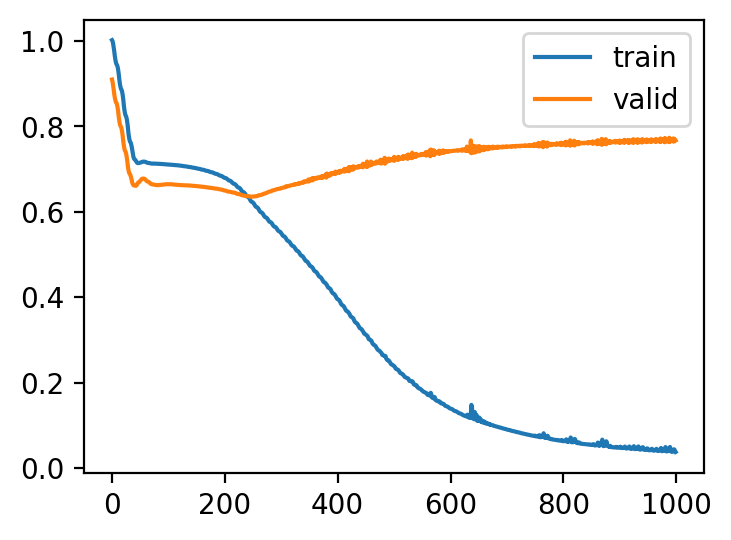

In [189]:
plt.figure(figsize=(4, 3), dpi=200)

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(trn_loss_history))
plt.plot(x, y, label='train')

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(val_loss_history))
plt.plot(x, y, label='valid')

plt.legend()
plt.show()

## BatchNormとDropout

In [58]:
# MIDDLE_LAYER = 300

# FC →Norm　→　ReLU →Dropout
        
# channelは３次元目の次数
class BnLayer(nn.Module):
    def __init__(self, D_in, D_out):
        super().__init__()
        self.fc = nn.Linear(
            D_in, D_out
        )
        self.bn = nn.BatchNorm1d(D_out)
        self.activation = nn.PReLU()
        self.dropout = nn.Dropout(p=0.2)

        
    def forward(self, X):
        # dropout入れよう！
        return self.activation(self.bn(self.fc(X)))
        

class BnNet(nn.Module):
    def __init__(self, D_in, layers, D_out):
        super(BnNet, self).__init__()
        # 大きさ変わらないConv　出力の次元が増える
        self.input_linear = nn.Linear(D_in, layers[0])
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
        self.output_linear = nn.Linear(layers[-1], D_out)
        
        
    def forward(self, X):
        X = self.input_linear(X)
        for layer in self.layers:
            X = layer(X)
        return self.output_linear(X)

In [64]:
# INPUT_FEATURES = X.shape[1]
# OUTPUT_NEURONS = 1

N_EPOCH = 1000
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [65]:
# 特徴量の数が不明でもConvから入れば問題ない

# ここのConvのchannel数は、考えないといけなさそう
D_IN = inps_train.size()[1]
LAYERS = [512] * 4
D_OUT = tgts_train.size()[1]
model = BnNet(D_IN, LAYERS, D_OUT)

In [66]:
print(model)

BnNet(
  (input_linear): Linear(in_features=2048, out_features=512, bias=True)
  (layers): ModuleList(
    (0): BnLayer(
      (fc): Linear(in_features=512, out_features=512, bias=True)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): PReLU(num_parameters=1)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): BnLayer(
      (fc): Linear(in_features=512, out_features=512, bias=True)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): PReLU(num_parameters=1)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (2): BnLayer(
      (fc): Linear(in_features=512, out_features=512, bias=True)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): PReLU(num_parameters=1)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (output_linear): Linear(in_features=512, out_features=1, bias=True)
)


In [67]:
# model = BasicCNN(INPUT_FEATURES, OUTPUT_NEURONS)
loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.03)

for epoch in range(N_EPOCH):
    
    inputs = inps_train.float().to(DEVICE)
    targets = tgts_train.float().to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_func(outputs, targets)
    loss.backward()

    optimizer.step()

    if epoch % 100 == 99:
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(loss.item()):.4f}')

print('Finish training')


model.eval()
with torch.no_grad():
    inputs = inps_test.float().to(DEVICE)
    targets = tgts_test.float().to(DEVICE)          
    outputs = model(inputs)

    loss = loss_func(outputs, targets)

print(f"Validation loss:{np.sqrt(loss.item()):.4f}")

Epoch: [100/1000], Loss: 0.2328
Epoch: [200/1000], Loss: 0.0592
Epoch: [300/1000], Loss: 0.0219
Epoch: [400/1000], Loss: 0.0134
Epoch: [500/1000], Loss: 0.0119
Epoch: [600/1000], Loss: 0.0117
Epoch: [700/1000], Loss: 0.0116
Epoch: [800/1000], Loss: 0.2433
Epoch: [900/1000], Loss: 0.0118
Epoch: [1000/1000], Loss: 0.0116
Finish training
Validation loss:0.7440


## LR range test

In [130]:
model = BnNet(D_IN, LAYERS, D_OUT)

loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=10**(1/5))

lr_history = []
loss_history = []

for epoch in range(N_EPOCH):
    inputs = inps_train.float().to(DEVICE)
    targets = tgts_train.float().to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_func(outputs, targets)
    loss.backward()
    
    optimizer.step()
    
#     lr_history.append(scheduler.get_lr())

    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    scheduler.step()

    lr_history.append(lr_step)
    loss_history.append(loss.item()) 
    
    if epoch == 23:
        break
    
#     if epoch % 100 == 99 or epoch == 0:
#         lr_history.append(scheduler.get_lr())
#         loss_history.append(loss.item())
#         print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(loss.item()):.4f}')

print('Finish training')

Finish training


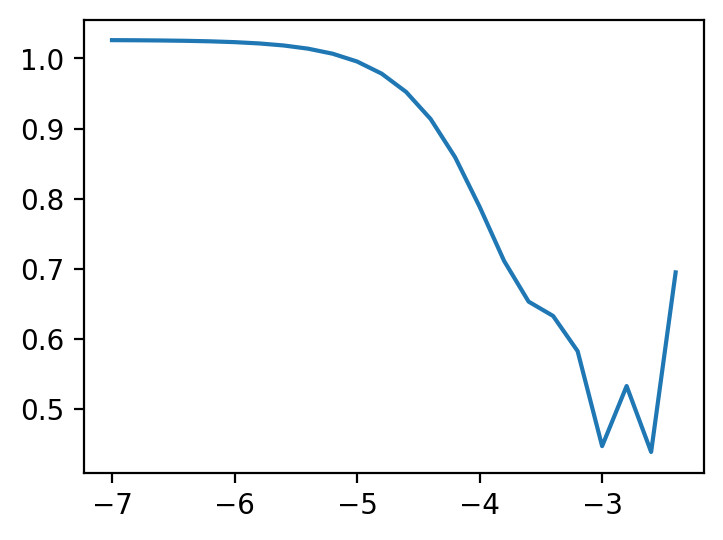

In [131]:
plt.figure(figsize=(4, 3), dpi=200)

x = np.log10(np.array(lr_history))
y = np.sqrt(np.array(loss_history))

plt.plot(x, y)
plt.show()

In [132]:
x

array([-7. , -6.8, -6.6, -6.4, -6.2, -6. , -5.8, -5.6, -5.4, -5.2, -5. ,
       -4.8, -4.6, -4.4, -4.2, -4. , -3.8, -3.6, -3.4, -3.2, -3. , -2.8,
       -2.6, -2.4])

In [134]:
max_lr = 10**(-2.6)/10
max_lr

0.00025118864315095795

In [135]:
max_lr / 6

4.186477385849299e-05

In [136]:
10**(-4.4)

3.9810717055349695e-05

max_lr: 0.00025  
base_lr: 0.00004

## CLR

* base_lr: Lossの変化が急になり始めた点
* max_lr: Lossの変化がなだらかになる直前の点
* step_size: 1Epochに回るイテレーションサイズ(つまり、学習データ量÷バッチサイズ)の2倍〜10倍

In [152]:
max_lr = 0.00025
base_lr = 0.00004

model = BnNet(D_IN, LAYERS, D_OUT)

loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=base_lr)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=4, cycle_momentum=False)

In [154]:
lr_history = []
val_loss_history = []
trn_loss_history = []

def validate():
    model.eval()
    with torch.no_grad():
        inputs = inps_test.float().to(DEVICE)
        targets = tgts_test.float().to(DEVICE)          
        outputs = model(inputs)

        loss = loss_func(outputs, targets)
    return loss.item()

for epoch in range(N_EPOCH):
    model.train()
    
    inputs = inps_train.float().to(DEVICE)
    targets = tgts_train.float().to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_func(outputs, targets)
    loss.backward()

    optimizer.step()
    
    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_history.append(lr_step)
    scheduler.step()
    
    trn_loss_history.append(loss.item())
    val_loss = validate()
    val_loss_history.append(val_loss)

    if epoch % 100 == 99:        
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(loss.item()):.4f}, Validation loss:{np.sqrt(val_loss):.4f}')

print('Finish training')


# print(f"Validation loss:{np.sqrt(loss.item()):.4f}")

Epoch: [100/1000], Loss: 0.0233, Validation loss:0.6082
Epoch: [200/1000], Loss: 0.0311, Validation loss:0.6020
Epoch: [300/1000], Loss: 0.0194, Validation loss:0.5986
Epoch: [400/1000], Loss: 0.0307, Validation loss:0.5956
Epoch: [500/1000], Loss: 0.0169, Validation loss:0.5948
Epoch: [600/1000], Loss: 0.0329, Validation loss:0.5933
Epoch: [700/1000], Loss: 0.0156, Validation loss:0.5928
Epoch: [800/1000], Loss: 0.0278, Validation loss:0.5910
Epoch: [900/1000], Loss: 0.0143, Validation loss:0.5894
Epoch: [1000/1000], Loss: 0.0264, Validation loss:0.5887
Finish training


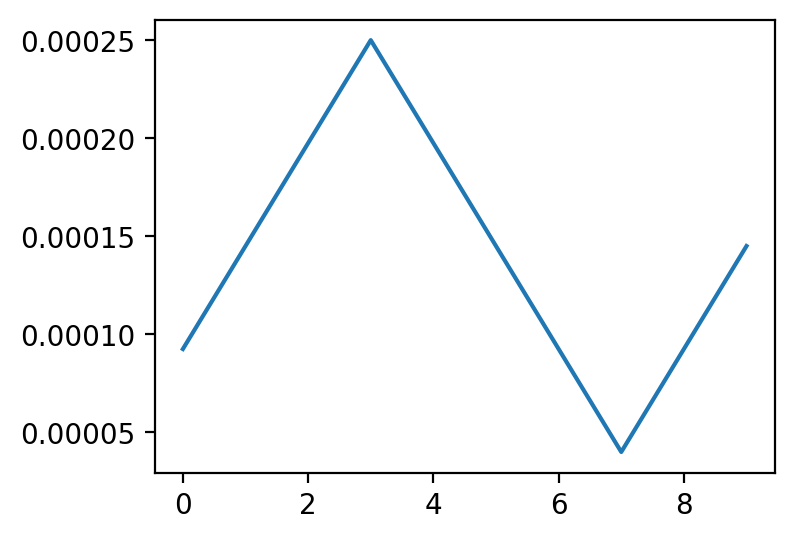

In [155]:
plt.figure(figsize=(4, 3), dpi=200)

x = [i for i in range(len(lr_history))][:10]
y = lr_history[:10]

plt.plot(x, y)
plt.show()

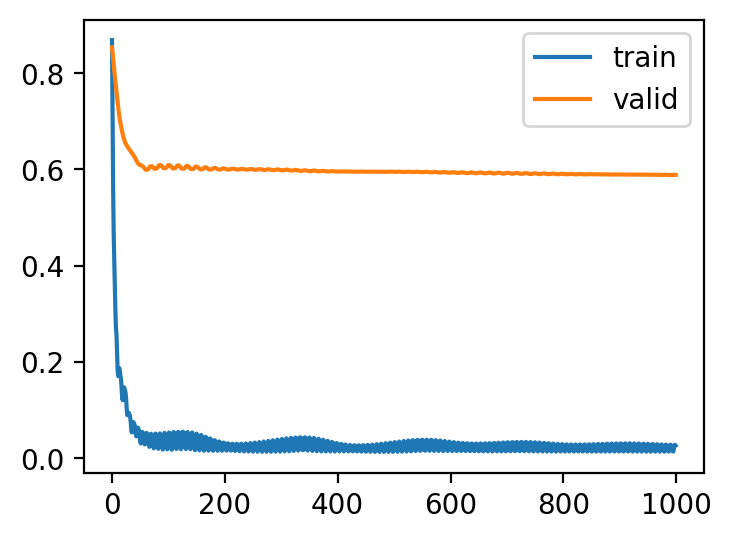

In [156]:
plt.figure(figsize=(4, 3), dpi=200)

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(trn_loss_history))
plt.plot(x, y, label='train')

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(val_loss_history))
plt.plot(x, y, label='valid')

plt.legend()
plt.show()

In [157]:
max_lr = 0.00025
base_lr = 0.00004

model = BnNet(D_IN, LAYERS, D_OUT)

loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=base_lr)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=20, cycle_momentum=False)

In [158]:
lr_history = []
val_loss_history = []
trn_loss_history = []

def validate():
    model.eval()
    with torch.no_grad():
        inputs = inps_test.float().to(DEVICE)
        targets = tgts_test.float().to(DEVICE)          
        outputs = model(inputs)

        loss = loss_func(outputs, targets)
    return loss.item()

for epoch in range(N_EPOCH):
    model.train()
    
    inputs = inps_train.float().to(DEVICE)
    targets = tgts_train.float().to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_func(outputs, targets)
    loss.backward()

    optimizer.step()
    
    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_history.append(lr_step)
    scheduler.step()
    
    trn_loss_history.append(loss.item())
    val_loss = validate()
    val_loss_history.append(val_loss)

    if epoch % 100 == 99:        
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(loss.item()):.4f}, Validation loss:{np.sqrt(val_loss):.4f}')

print('Finish training')


# print(f"Validation loss:{np.sqrt(loss.item()):.4f}")

Epoch: [100/1000], Loss: 0.0118, Validation loss:0.6568
Epoch: [200/1000], Loss: 0.0116, Validation loss:0.6568
Epoch: [300/1000], Loss: 0.0161, Validation loss:0.6541
Epoch: [400/1000], Loss: 0.0116, Validation loss:0.6551
Epoch: [500/1000], Loss: 0.0116, Validation loss:0.6551
Epoch: [600/1000], Loss: 0.0116, Validation loss:0.6551
Epoch: [700/1000], Loss: 0.0116, Validation loss:0.6551
Epoch: [800/1000], Loss: 0.0116, Validation loss:0.6551
Epoch: [900/1000], Loss: 0.0116, Validation loss:0.6551
Epoch: [1000/1000], Loss: 0.0116, Validation loss:0.6551
Finish training


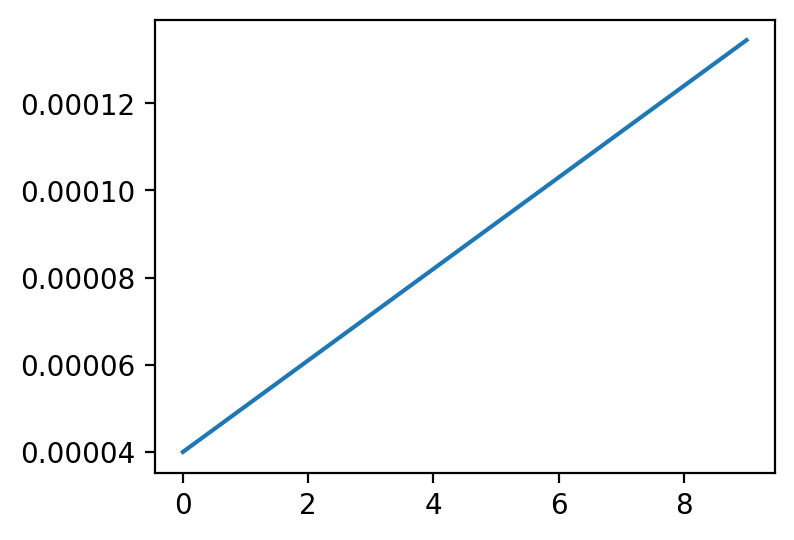

In [159]:
plt.figure(figsize=(4, 3), dpi=200)

x = [i for i in range(len(lr_history))]
y = lr_history

plt.plot(x, y)
plt.show()

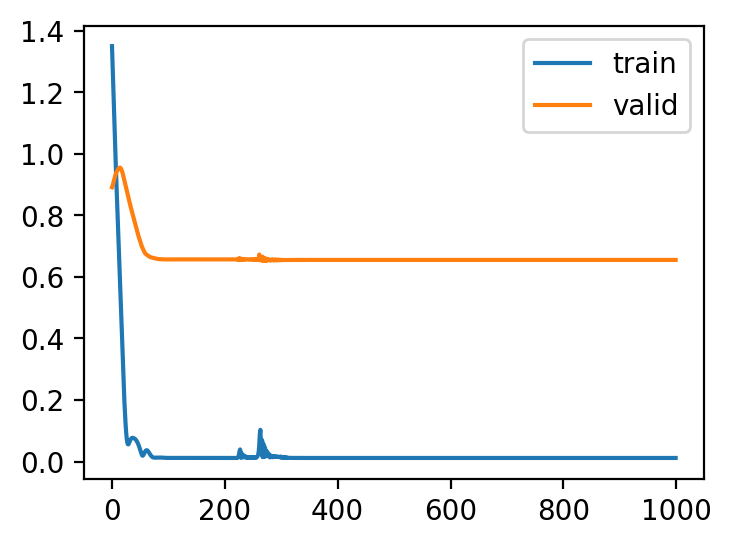

In [160]:
plt.figure(figsize=(4, 3), dpi=200)

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(trn_loss_history))
plt.plot(x, y, label='train')

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(val_loss_history))
plt.plot(x, y, label='valid')

plt.legend()
plt.show()

In [161]:
max_lr = 0.00025
base_lr = 0.00004

model = BnNet(D_IN, LAYERS, D_OUT)

loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=base_lr)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=100, cycle_momentum=False)

In [162]:
lr_history = []
val_loss_history = []
trn_loss_history = []

def validate():
    model.eval()
    with torch.no_grad():
        inputs = inps_test.float().to(DEVICE)
        targets = tgts_test.float().to(DEVICE)          
        outputs = model(inputs)

        loss = loss_func(outputs, targets)
    return loss.item()

for epoch in range(N_EPOCH):
    model.train()
    
    inputs = inps_train.float().to(DEVICE)
    targets = tgts_train.float().to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_func(outputs, targets)
    loss.backward()

    optimizer.step()
    
    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_history.append(lr_step)
    scheduler.step()
    
    trn_loss_history.append(loss.item())
    val_loss = validate()
    val_loss_history.append(val_loss)

    if epoch % 100 == 99:        
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(loss.item()):.4f}, Validation loss:{np.sqrt(val_loss):.4f}')

print('Finish training')


# print(f"Validation loss:{np.sqrt(loss.item()):.4f}")

Epoch: [100/1000], Loss: 0.0122, Validation loss:0.6636
Epoch: [200/1000], Loss: 0.0116, Validation loss:0.6640
Epoch: [300/1000], Loss: 0.0116, Validation loss:0.6640
Epoch: [400/1000], Loss: 0.0116, Validation loss:0.6640
Epoch: [500/1000], Loss: 0.0116, Validation loss:0.6640
Epoch: [600/1000], Loss: 0.0116, Validation loss:0.6640
Epoch: [700/1000], Loss: 0.0116, Validation loss:0.6640
Epoch: [800/1000], Loss: 0.0116, Validation loss:0.6640
Epoch: [900/1000], Loss: 0.0149, Validation loss:0.6726
Epoch: [1000/1000], Loss: 0.0116, Validation loss:0.6004
Finish training


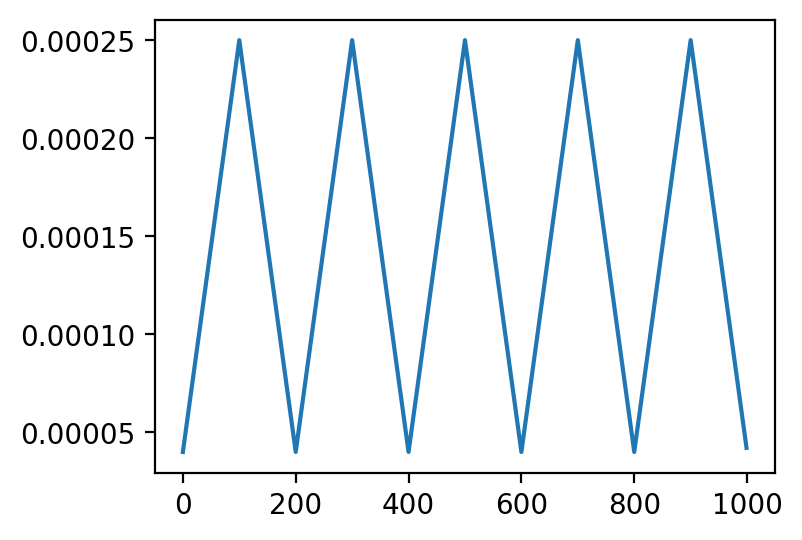

In [165]:
plt.figure(figsize=(4, 3), dpi=200)

x = [i for i in range(len(lr_history))]
y = lr_history

plt.plot(x, y)
plt.show()

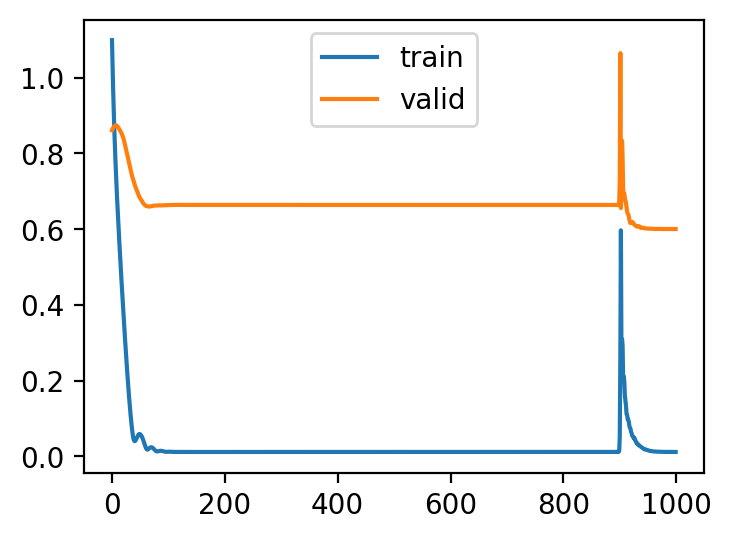

In [164]:
plt.figure(figsize=(4, 3), dpi=200)

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(trn_loss_history))
plt.plot(x, y, label='train')

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(val_loss_history))
plt.plot(x, y, label='valid')

plt.legend()
plt.show()

## BatchNormとDropout Conv

In [203]:
# MIDDLE_LAYER = 300

# FC →Norm　→　ReLU →Dropout

# channelは３次元目の次数
class BnLayer(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=2):
        super().__init__()
#         self.fc = nn.Linear(in_chan, out_chan)
        self.bn = nn.BatchNorm1d(out_channel)
        # sizeが半分になるconvolution 2048 →1024　→ 512
        self.conv = nn.Conv1d(
            in_channel, out_channel,
            kernel_size=kernel_size, stride=stride, padding=1, bias=False
        )
        self.activation = nn.PReLU()
        self.dropout = nn.Dropout(p=0.2)

        
    def forward(self, X):
        return self.dropout(self.activation(self.bn(self.conv(X))))
        

class ConvBnNet(nn.Module):
    def __init__(self, layers, D_out):
        super(ConvBnNet, self).__init__()
        # 大きさ変わらないConv　出力の次元が増える
        self.conv1 = nn.Conv1d(1, layers[0], kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], D_out)
        
        
    def forward(self, X):
        X = X.view(-1, 1, X.size(1))
        X = self.conv1(X)
        for layer in self.layers:
            X = layer(X)
        # channelを統合
        X = F.adaptive_avg_pool1d(X, 1)
        X = X.view(X.size(0), -1)
        return self.out(X)

In [204]:
# INPUT_FEATURES = X.shape[1]
# OUTPUT_NEURONS = 1

N_EPOCH = 1000
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [205]:
# 特徴量の数が不明でもConvから入れば問題ない

# ここのConvのchannel数は、考えないといけなさそう
LAYERS = [2, 4, 8, 16]
D_OUT = 1
model = ConvBnNet(LAYERS, D_OUT)
print(model)

ConvBnNet(
  (conv1): Conv1d(1, 2, kernel_size=(5,), stride=(1,), padding=(2,))
  (layers): ModuleList(
    (0): BnLayer(
      (bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv): Conv1d(2, 4, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
      (activation): PReLU(num_parameters=1)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): BnLayer(
      (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv): Conv1d(4, 8, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
      (activation): PReLU(num_parameters=1)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (2): BnLayer(
      (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv): Conv1d(8, 16, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
      (activation): PReLU(num_parameters=1)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (out): Linear(in_f

In [206]:
# 特徴量の数が不明でもConvから入れば問題ない

# ここのConvのchannel数は、考えないといけなさそう
# LAYERS = [10, 20, 40, 80]
# OUT_DIM = 1

max_lr = 0.00025
base_lr = 0.00004

loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=base_lr)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=4, cycle_momentum=False)

In [207]:
lr_history = []
val_loss_history = []
trn_loss_history = []

def validate():
    model.eval()
    with torch.no_grad():
        inputs = inps_test.float().to(DEVICE)
        targets = tgts_test.float().to(DEVICE)          
        outputs = model(inputs)

        loss = loss_func(outputs, targets)
    return loss.item()

for epoch in range(N_EPOCH):
    model.train()
    
    inputs = inps_train.float().to(DEVICE)
    targets = tgts_train.float().to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_func(outputs, targets)
    loss.backward()

    optimizer.step()
    
    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_history.append(lr_step)
    scheduler.step()
    
    trn_loss_history.append(loss.item())
    val_loss = validate()
    val_loss_history.append(val_loss)

    if epoch % 100 == 99:        
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(loss.item()):.4f}, Validation loss:{np.sqrt(val_loss):.4f}')

print('Finish training')


# print(f"Validation loss:{np.sqrt(loss.item()):.4f}")

Epoch: [100/1000], Loss: 0.9365, Validation loss:0.8342
Epoch: [200/1000], Loss: 0.8696, Validation loss:0.7809
Epoch: [300/1000], Loss: 0.8167, Validation loss:0.7354
Epoch: [400/1000], Loss: 0.7748, Validation loss:0.7002
Epoch: [500/1000], Loss: 0.7464, Validation loss:0.6771
Epoch: [600/1000], Loss: 0.7276, Validation loss:0.6644
Epoch: [700/1000], Loss: 0.7191, Validation loss:0.6589
Epoch: [800/1000], Loss: 0.7128, Validation loss:0.6570
Epoch: [900/1000], Loss: 0.7101, Validation loss:0.6564
Epoch: [1000/1000], Loss: 0.7082, Validation loss:0.6556
Finish training


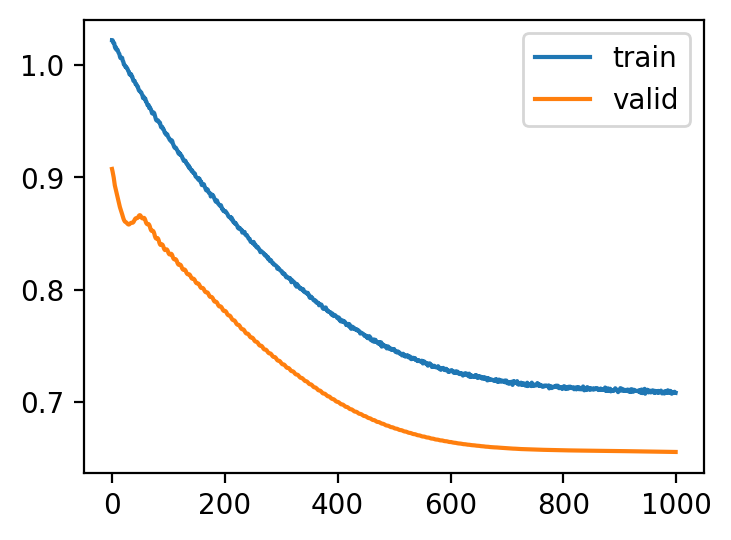

In [208]:
plt.figure(figsize=(4, 3), dpi=200)

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(trn_loss_history))
plt.plot(x, y, label='train')

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(val_loss_history))
plt.plot(x, y, label='valid')

plt.legend()
plt.show()

## BatchNorm & dropout

上で実装したやつ、dropout効いていない買ったのでもう一回やってみた

In [209]:
# MIDDLE_LAYER = 300

# FC →Norm　→　ReLU →Dropout
        
# channelは３次元目の次数
class BnLayer(nn.Module):
    def __init__(self, D_in, D_out):
        super().__init__()
        self.fc = nn.Linear(
            D_in, D_out
        )
        self.bn = nn.BatchNorm1d(D_out)
        self.activation = nn.PReLU()
        self.dropout = nn.Dropout(p=0.2)

        
    def forward(self, X):
        return self.dropout(self.activation(self.bn(self.fc(X))))
        

class BnNet(nn.Module):
    def __init__(self, D_in, layers, D_out):
        super(BnNet, self).__init__()
        # 大きさ変わらないConv　出力の次元が増える
        self.input_linear = nn.Linear(D_in, layers[0])
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
        self.output_linear = nn.Linear(layers[-1], D_out)
        
        
    def forward(self, X):
        X = self.input_linear(X)
        for layer in self.layers:
            X = layer(X)
        return self.output_linear(X)

In [210]:
# INPUT_FEATURES = X.shape[1]
# OUTPUT_NEURONS = 1

N_EPOCH = 1000
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [211]:
# 特徴量の数が不明でもConvから入れば問題ない

# ここのConvのchannel数は、考えないといけなさそう
D_IN = inps_train.size()[1]
LAYERS = [512] * 4
D_OUT = tgts_train.size()[1]
model = BnNet(D_IN, LAYERS, D_OUT)

In [212]:
print(model)

BnNet(
  (input_linear): Linear(in_features=2048, out_features=512, bias=True)
  (layers): ModuleList(
    (0): BnLayer(
      (fc): Linear(in_features=512, out_features=512, bias=True)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): PReLU(num_parameters=1)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): BnLayer(
      (fc): Linear(in_features=512, out_features=512, bias=True)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): PReLU(num_parameters=1)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (2): BnLayer(
      (fc): Linear(in_features=512, out_features=512, bias=True)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): PReLU(num_parameters=1)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (output_linear): Linear(in_features=512, out_features=1, bias=True)
)


In [213]:
# model = BasicCNN(INPUT_FEATURES, OUTPUT_NEURONS)
loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.03)

for epoch in range(N_EPOCH):
    
    inputs = inps_train.float().to(DEVICE)
    targets = tgts_train.float().to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_func(outputs, targets)
    loss.backward()

    optimizer.step()

    if epoch % 100 == 99:
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(loss.item()):.4f}')

print('Finish training')


model.eval()
with torch.no_grad():
    inputs = inps_test.float().to(DEVICE)
    targets = tgts_test.float().to(DEVICE)          
    outputs = model(inputs)

    loss = loss_func(outputs, targets)

print(f"Validation loss:{np.sqrt(loss.item()):.4f}")

Epoch: [100/1000], Loss: 0.6001
Epoch: [200/1000], Loss: 0.3095
Epoch: [300/1000], Loss: 0.1616
Epoch: [400/1000], Loss: 0.1477
Epoch: [500/1000], Loss: 0.1145
Epoch: [600/1000], Loss: 0.1127
Epoch: [700/1000], Loss: 0.1010
Epoch: [800/1000], Loss: 0.0839
Epoch: [900/1000], Loss: 0.0862
Epoch: [1000/1000], Loss: 0.0802
Finish training
Validation loss:0.6644


## LR range test

In [218]:
model = BnNet(D_IN, LAYERS, D_OUT)

loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=10**(1/5))

lr_history = []
loss_history = []

for epoch in range(N_EPOCH):
    inputs = inps_train.float().to(DEVICE)
    targets = tgts_train.float().to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_func(outputs, targets)
    loss.backward()
    
    optimizer.step()
    
#     lr_history.append(scheduler.get_lr())

    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    scheduler.step()

    lr_history.append(lr_step)
    loss_history.append(loss.item()) 
    
    if epoch == 24:
        break
    
#     if epoch % 100 == 99 or epoch == 0:
#         lr_history.append(scheduler.get_lr())
#         loss_history.append(loss.item())
#         print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(loss.item()):.4f}')

print('Finish training')

Finish training


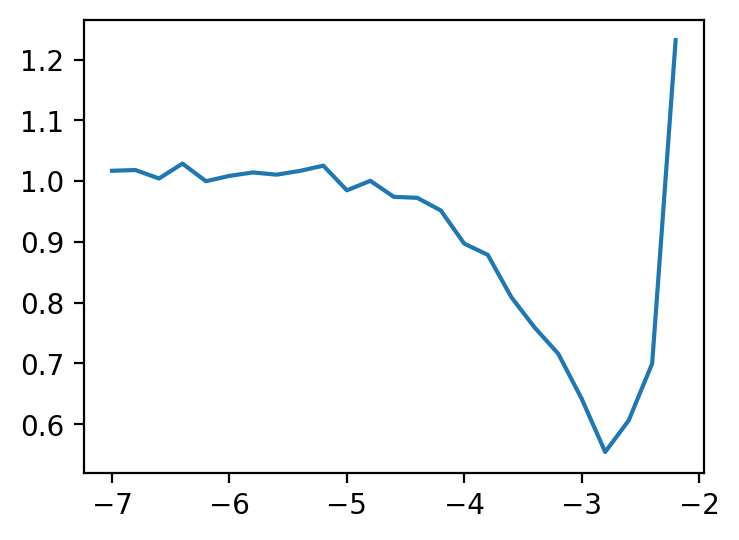

In [219]:
plt.figure(figsize=(4, 3), dpi=200)

x = np.log10(np.array(lr_history))
y = np.sqrt(np.array(loss_history))

plt.plot(x, y)
plt.show()

In [220]:
x

array([-7. , -6.8, -6.6, -6.4, -6.2, -6. , -5.8, -5.6, -5.4, -5.2, -5. ,
       -4.8, -4.6, -4.4, -4.2, -4. , -3.8, -3.6, -3.4, -3.2, -3. , -2.8,
       -2.6, -2.4, -2.2])

In [221]:
max_lr = 10**(-2.6)/10
max_lr

0.00025118864315095795

In [222]:
max_lr / 6

4.186477385849299e-05

In [223]:
10**(-4.4)

3.9810717055349695e-05

max_lr: 0.00025  
base_lr: 0.00004

## CLR

* base_lr: Lossの変化が急になり始めた点
* max_lr: Lossの変化がなだらかになる直前の点
* step_size: 1Epochに回るイテレーションサイズ(つまり、学習データ量÷バッチサイズ)の2倍〜10倍

In [224]:
max_lr = 0.00025
base_lr = 0.00004

model = BnNet(D_IN, LAYERS, D_OUT)

loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=base_lr)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=4, cycle_momentum=False)

In [225]:
lr_history = []
val_loss_history = []
trn_loss_history = []

def validate():
    model.eval()
    with torch.no_grad():
        inputs = inps_test.float().to(DEVICE)
        targets = tgts_test.float().to(DEVICE)          
        outputs = model(inputs)

        loss = loss_func(outputs, targets)
    return loss.item()

for epoch in range(N_EPOCH):
    model.train()
    
    inputs = inps_train.float().to(DEVICE)
    targets = tgts_train.float().to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_func(outputs, targets)
    loss.backward()

    optimizer.step()
    
    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_history.append(lr_step)
    scheduler.step()
    
    trn_loss_history.append(loss.item())
    val_loss = validate()
    val_loss_history.append(val_loss)

    if epoch % 100 == 99:        
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(loss.item()):.4f}, Validation loss:{np.sqrt(val_loss):.4f}')

print('Finish training')


# print(f"Validation loss:{np.sqrt(loss.item()):.4f}")

Epoch: [100/1000], Loss: 0.2657, Validation loss:0.6106
Epoch: [200/1000], Loss: 0.2352, Validation loss:0.6106
Epoch: [300/1000], Loss: 0.1871, Validation loss:0.6090
Epoch: [400/1000], Loss: 0.1687, Validation loss:0.6173
Epoch: [500/1000], Loss: 0.1444, Validation loss:0.6116
Epoch: [600/1000], Loss: 0.1230, Validation loss:0.6119
Epoch: [700/1000], Loss: 0.1255, Validation loss:0.6206
Epoch: [800/1000], Loss: 0.1106, Validation loss:0.6278
Epoch: [900/1000], Loss: 0.0976, Validation loss:0.6319
Epoch: [1000/1000], Loss: 0.0920, Validation loss:0.6351
Finish training


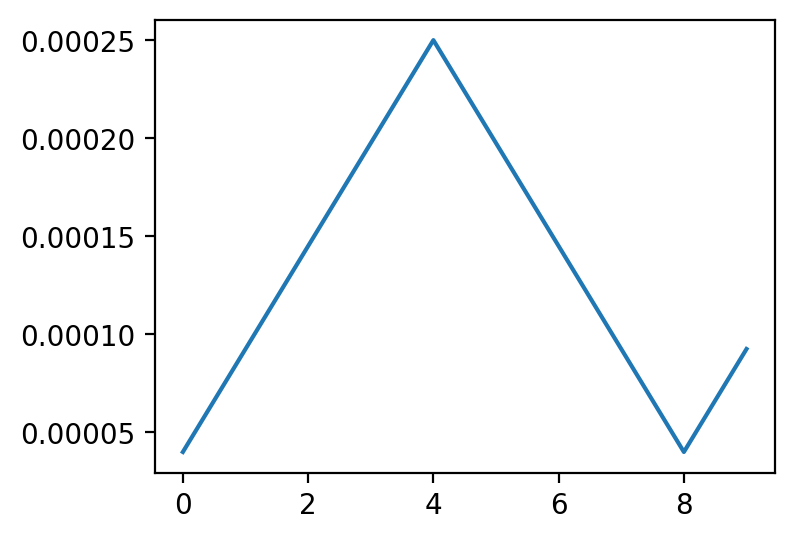

In [226]:
plt.figure(figsize=(4, 3), dpi=200)

x = [i for i in range(len(lr_history))][:10]
y = lr_history[:10]

plt.plot(x, y)
plt.show()

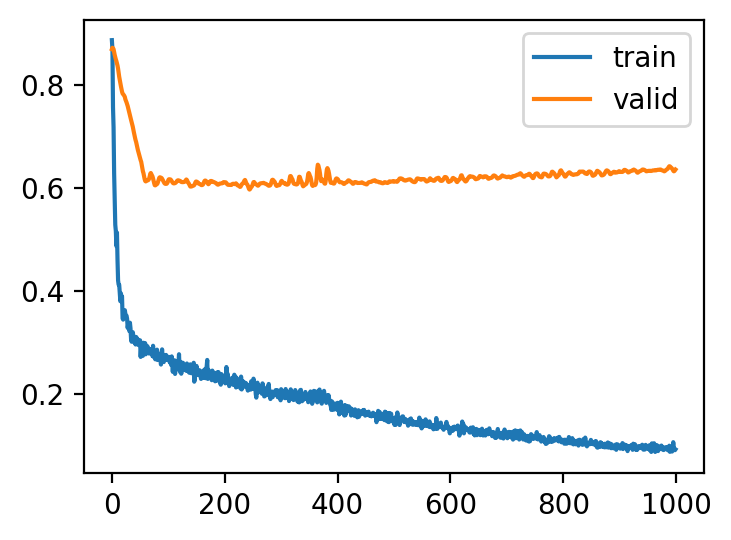

In [227]:
plt.figure(figsize=(4, 3), dpi=200)

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(trn_loss_history))
plt.plot(x, y, label='train')

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(val_loss_history))
plt.plot(x, y, label='valid')

plt.legend()
plt.show()

## ResNet

In [247]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [242]:
class BnLayer(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size=3, stride=2):
        super().__init__()
        self.conv = nn.Conv1d(in_chan, out_chan, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, bias=False)
        self.bn = nn.BatchNorm1d(out_chan)
        self.activation = nn.PReLU()
        self.dropout = nn.Dropout(p=.2)
        
    def forward(self, x):
        return self.dropout(self.activation(self.bn(self.conv(x))))

    
class ResnetLayer(BnLayer):
    def forward(self, x):
        return x + super().forward(x)
    
class ResNet(nn.Module):
    def __init__(self, layers, D_out, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 2, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.layers1 = nn.ModuleList([BnLayer(layers[i], layers[i+1], kernel_size=kernel_size) for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], kernel_size, stride=1) for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], kernel_size, stride=1) for i in range(len(layers) - 1)])
        self.output_layer = nn.Linear(layers[-1], D_out)
        
    def forward(self, x):
        x = x.view(-1, 1, x.size(1))
        x = self.conv1(x)
        for layer1, layer2, layer3 in zip(self.layers1, self.layers2, self.layers3):
            x = layer3(layer2(layer1(x)))
        x = F.adaptive_max_pool1d(x, 1)
        x = x.view(x.size(0), -1)
        return self.output_layer(x)

In [248]:
layers = [2, 4, 8, 16 ,32]
D_out = 1
kernel_size = 51
model = ResNet(layers, D_out, kernel_size)
print(count_parameters(model), count_trainable_parameters(model))

173909 173909


In [244]:
# 特徴量の数が不明でもConvから入れば問題ない

# ここのConvのchannel数は、考えないといけなさそう
# LAYERS = [10, 20, 40, 80]
# OUT_DIM = 1

max_lr = 0.00025
base_lr = 0.00004

loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=base_lr)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=4, cycle_momentum=False)

In [245]:
lr_history = []
val_loss_history = []
trn_loss_history = []

def validate():
    model.eval()
    with torch.no_grad():
        inputs = inps_test.float().to(DEVICE)
        targets = tgts_test.float().to(DEVICE)          
        outputs = model(inputs)

        loss = loss_func(outputs, targets)
    return loss.item()

for epoch in range(N_EPOCH):
    model.train()
    
    inputs = inps_train.float().to(DEVICE)
    targets = tgts_train.float().to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_func(outputs, targets)
    loss.backward()

    optimizer.step()
    
    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_history.append(lr_step)
    scheduler.step()
    
    trn_loss_history.append(loss.item())
    val_loss = validate()
    val_loss_history.append(val_loss)

    if epoch % 100 == 99:        
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(loss.item()):.4f}, Validation loss:{np.sqrt(val_loss):.4f}')

print('Finish training')


# print(f"Validation loss:{np.sqrt(loss.item()):.4f}")

Epoch: [100/1000], Loss: 0.7887, Validation loss:0.7683
Epoch: [200/1000], Loss: 0.6986, Validation loss:0.7819
Epoch: [300/1000], Loss: 0.6566, Validation loss:0.7074
Epoch: [400/1000], Loss: 0.6130, Validation loss:0.6870
Epoch: [500/1000], Loss: 0.5690, Validation loss:0.7129
Epoch: [600/1000], Loss: 0.5029, Validation loss:0.6958
Epoch: [700/1000], Loss: 0.4752, Validation loss:0.6765
Epoch: [800/1000], Loss: 0.4318, Validation loss:0.6879
Epoch: [900/1000], Loss: 0.3699, Validation loss:0.6884
Epoch: [1000/1000], Loss: 0.3584, Validation loss:0.6964
Finish training


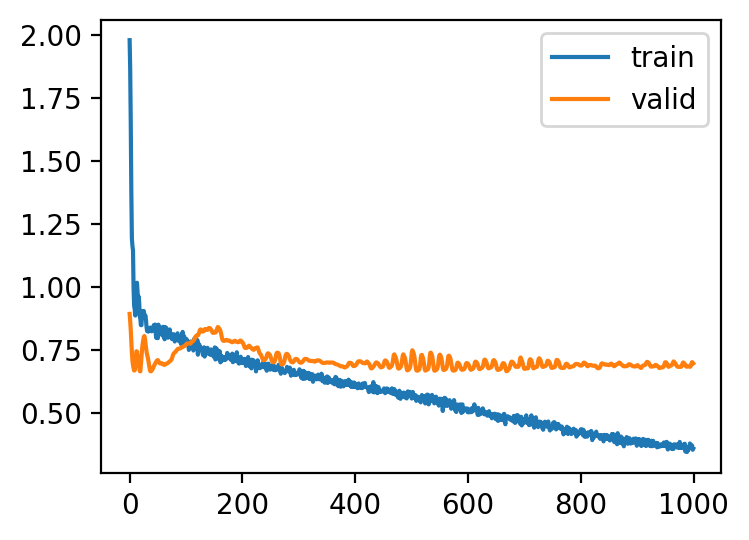

In [246]:
plt.figure(figsize=(4, 3), dpi=200)

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(trn_loss_history))
plt.plot(x, y, label='train')

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(val_loss_history))
plt.plot(x, y, label='valid')

plt.legend()
plt.show()

## ResNet いろいろいじる

In [247]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [268]:
class BnLayer(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size=3, stride=2):
        super().__init__()
        self.conv = nn.Conv1d(in_chan, out_chan, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, bias=False)
        self.bn = nn.BatchNorm1d(out_chan)
        self.activation = nn.PReLU()
        self.dropout = nn.Dropout(p=.2)
        
    def forward(self, x):
        return self.dropout(self.activation(self.bn(self.conv(x))))

    
class ResnetLayer(BnLayer):
    def forward(self, x):
        return x + super().forward(x)
    
class ResNet(nn.Module):
    def __init__(self, layers, D_out, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 2, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(2)
        self.relu = nn.PReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=kernel_size, stride=2, padding=kernel_size//2)
        self.layers1 = nn.ModuleList([BnLayer(layers[i], layers[i+1], kernel_size=kernel_size) for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], kernel_size, stride=1) for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], kernel_size, stride=1) for i in range(len(layers) - 1)])
#         self.dropout = nn.Dropout(p=.2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.output_layer = nn.Linear(layers[-1], D_out)
        
    def forward(self, x):
        x = x.view(-1, 1, x.size(1))
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        for layer1, layer2, layer3 in zip(self.layers1, self.layers2, self.layers3):
            x = layer3(layer2(layer1(x)))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.output_layer(x)

In [269]:
layers = [2, 4, 8]
D_out = 1
kernel_size = 51
model = ResNet(layers, D_out, kernel_size)
print(count_parameters(model), count_trainable_parameters(model))

10396 10396


In [270]:
# 特徴量の数が不明でもConvから入れば問題ない

# ここのConvのchannel数は、考えないといけなさそう
# LAYERS = [10, 20, 40, 80]
# OUT_DIM = 1

max_lr = 0.00025
base_lr = 0.00004

loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=base_lr)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=4, cycle_momentum=False)

In [271]:
lr_history = []
val_loss_history = []
trn_loss_history = []

def validate():
    model.eval()
    with torch.no_grad():
        inputs = inps_test.float().to(DEVICE)
        targets = tgts_test.float().to(DEVICE)          
        outputs = model(inputs)

        loss = loss_func(outputs, targets)
    return loss.item()

for epoch in range(N_EPOCH):
    model.train()
    
    inputs = inps_train.float().to(DEVICE)
    targets = tgts_train.float().to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_func(outputs, targets)
    loss.backward()

    optimizer.step()
    
    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_history.append(lr_step)
    scheduler.step()
    
    trn_loss_history.append(loss.item())
    val_loss = validate()
    val_loss_history.append(val_loss)

    if epoch % 100 == 99:        
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(loss.item()):.4f}, Validation loss:{np.sqrt(val_loss):.4f}')

print('Finish training')


# print(f"Validation loss:{np.sqrt(loss.item()):.4f}")

Epoch: [100/1000], Loss: 0.7479, Validation loss:0.6950
Epoch: [200/1000], Loss: 0.6961, Validation loss:0.6735
Epoch: [300/1000], Loss: 0.6565, Validation loss:0.6770
Epoch: [400/1000], Loss: 0.6344, Validation loss:0.7107
Epoch: [500/1000], Loss: 0.6060, Validation loss:0.7254
Epoch: [600/1000], Loss: 0.5986, Validation loss:0.7497
Epoch: [700/1000], Loss: 0.5800, Validation loss:0.7557
Epoch: [800/1000], Loss: 0.5704, Validation loss:0.8224
Epoch: [900/1000], Loss: 0.5503, Validation loss:0.7517
Epoch: [1000/1000], Loss: 0.5400, Validation loss:0.7465
Finish training


過学習気味  
もっとlayerを薄くした方がいい

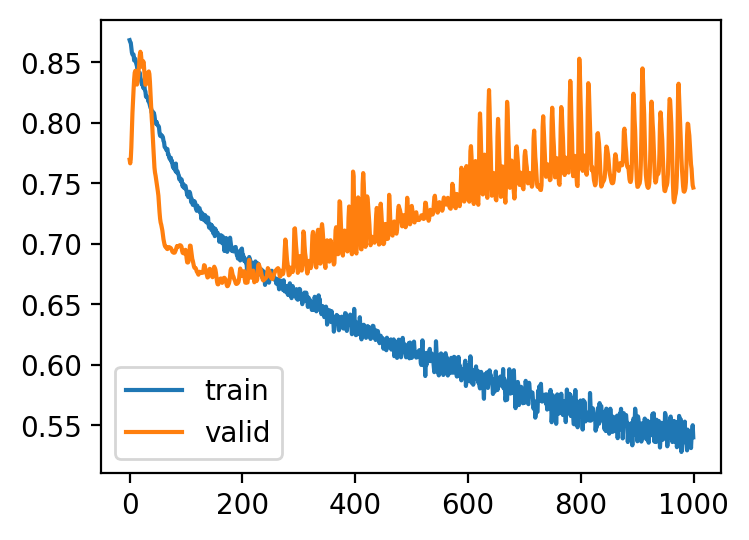

In [272]:
plt.figure(figsize=(4, 3), dpi=200)

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(trn_loss_history))
plt.plot(x, y, label='train')

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(val_loss_history))
plt.plot(x, y, label='valid')

plt.legend()
plt.show()

## ResNet bottleneck

In [242]:
class BnLayer(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size=3, stride=2):
        super().__init__()
        self.conv = nn.Conv1d(in_chan, out_chan, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, bias=False)
        self.bn = nn.BatchNorm1d(out_chan)
        self.activation = nn.PReLU()
        self.dropout = nn.Dropout(p=.2)
        
    def forward(self, x):
        return self.dropout(self.activation(self.bn(self.conv(x))))

    
# class ResnetLayer(BnLayer):
#     def forward(self, x):
#         return x + super().forward(x)
    

def conv1(in_lines, out_lines, stride=1):
    return nn.Conv1d(in_lines, out_lines, kernel_size=1, stride=stride, bias=False)


def conv3(in_lines, out_lines, stride=1):
    return nn.Conv1d(in_lines, out_lines, kernel_size=3, stride=stride, padding=1, bias=False)
    
    
class BottleneckLayer(BnLayer):
    def __init__(self, in_lines=64, *args, **kwargs):
        super().__init__(*args, **kwargs)
        width = in_lines // 2
        self.conv1 = conv1(in_lines, width)
        self.bn1 = nn.BachNorm1d(width)
        self.conv2 = conv3(width, width, stride=1)
        self.bn2 = nn.BachNorm1d(width)
        self.conv3 = conv1(width, in_lines)
        self.bn3 = nn.BachNorm1d(in_lines)
        self.relu = nn.ReLU()
    
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        return out + super().forward(identity)
    
    
# class Bottleneck(nn.Module):
#     def __init__(self, in_lines=64):
#         width = in_lines // 2
#         self.conv1 = conv1(in_lines, width)
#         self.bn1 = nn.BachNorm1d(width)
#         self.conv2 = conv3(width, width, stride=1)
#         self.bn2 = nn.BachNorm1d(width)
#         self.conv3 = conv1(width, in_lines)
#         self.bn3 = nn.BachNorm1d(in_lines)
#         self.relu = nn.ReLU()
        
#     def forward(self, x):
#         identity = x
        
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)
        
#         out = self.conv2(out)
#         out = self.bn2(out)
#         out = self.relu(out)
        
#         out = self.conv3(out)
#         out = self.bn3(out)
        
#         out += identity
#         return self.relu(out)
        
    
class ResNet(nn.Module):
    def __init__(self, layers, D_out, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 2, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.layers1 = nn.ModuleList([BnLayer(layers[i], layers[i+1], kernel_size=kernel_size) for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([Bottleneck(layers[i+1], layers[i+1], kernel_size, stride=1) for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([Bottleneck(layers[i+1], layers[i+1], kernel_size, stride=1) for i in range(len(layers) - 1)])
        self.output_layer = nn.Linear(layers[-1], D_out)
        
    def forward(self, x):
        x = x.view(-1, 1, x.size(1))
        x = self.conv1(x)
        for layer1, layer2, layer3 in zip(self.layers1, self.layers2, self.layers3):
            x = layer3(layer2(layer1(x)))
        x = F.adaptive_max_pool1d(x, 1)
        x = x.view(x.size(0), -1)
        return self.output_layer(x)

In [243]:
layers = [2, 4, 8, 16 ,32]
D_out = 1
kernel_size = 51
model = ResNet(layers, D_out, kernel_size)
print(count_parameters(model), count_trainable_parameters(model))

ResNet(
  (conv1): Conv1d(1, 2, kernel_size=(51,), stride=(1,), padding=(25,))
  (layers1): ModuleList(
    (0): BnLayer(
      (conv): Conv1d(2, 4, kernel_size=(51,), stride=(2,), padding=(25,), bias=False)
      (bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): PReLU(num_parameters=1)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): BnLayer(
      (conv): Conv1d(4, 8, kernel_size=(51,), stride=(2,), padding=(25,), bias=False)
      (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): PReLU(num_parameters=1)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (2): BnLayer(
      (conv): Conv1d(8, 16, kernel_size=(51,), stride=(2,), padding=(25,), bias=False)
      (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): PReLU(num_parameters=1)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (3): BnLayer(


In [244]:
# 特徴量の数が不明でもConvから入れば問題ない

# ここのConvのchannel数は、考えないといけなさそう
# LAYERS = [10, 20, 40, 80]
# OUT_DIM = 1

max_lr = 0.00025
base_lr = 0.00004

loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=base_lr)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=4, cycle_momentum=False)

In [245]:
lr_history = []
val_loss_history = []
trn_loss_history = []

def validate():
    model.eval()
    with torch.no_grad():
        inputs = inps_test.float().to(DEVICE)
        targets = tgts_test.float().to(DEVICE)          
        outputs = model(inputs)

        loss = loss_func(outputs, targets)
    return loss.item()

for epoch in range(N_EPOCH):
    model.train()
    
    inputs = inps_train.float().to(DEVICE)
    targets = tgts_train.float().to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_func(outputs, targets)
    loss.backward()

    optimizer.step()
    
    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_history.append(lr_step)
    scheduler.step()
    
    trn_loss_history.append(loss.item())
    val_loss = validate()
    val_loss_history.append(val_loss)

    if epoch % 100 == 99:        
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(loss.item()):.4f}, Validation loss:{np.sqrt(val_loss):.4f}')

print('Finish training')


# print(f"Validation loss:{np.sqrt(loss.item()):.4f}")

Epoch: [100/1000], Loss: 0.7887, Validation loss:0.7683
Epoch: [200/1000], Loss: 0.6986, Validation loss:0.7819
Epoch: [300/1000], Loss: 0.6566, Validation loss:0.7074
Epoch: [400/1000], Loss: 0.6130, Validation loss:0.6870
Epoch: [500/1000], Loss: 0.5690, Validation loss:0.7129
Epoch: [600/1000], Loss: 0.5029, Validation loss:0.6958
Epoch: [700/1000], Loss: 0.4752, Validation loss:0.6765
Epoch: [800/1000], Loss: 0.4318, Validation loss:0.6879
Epoch: [900/1000], Loss: 0.3699, Validation loss:0.6884
Epoch: [1000/1000], Loss: 0.3584, Validation loss:0.6964
Finish training


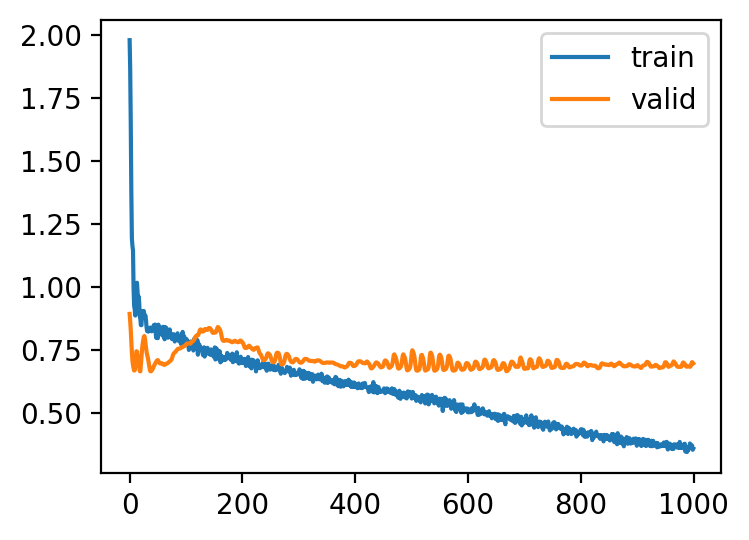

In [246]:
plt.figure(figsize=(4, 3), dpi=200)

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(trn_loss_history))
plt.plot(x, y, label='train')

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(val_loss_history))
plt.plot(x, y, label='valid')

plt.legend()
plt.show()

## 論文のアーキテクチャを真似してみる

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [41]:
class ConvLayer(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size=51, stride=1):
        super().__init__()
        self.conv = nn.Conv1d(in_chan, out_chan, kernel_size=kernel_size, stride=1, padding=kernel_size//2, bias=False)
        self.bn = nn.BatchNorm1d(out_chan)
        self.activation = nn.PReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=kernel_size//2)
        self.dropout = nn.Dropout(p=.2)
    
    
    def forward(self, x):
        return self.dropout(self.maxpool(self.activation(self.bn(self.conv(x)))))
    
    
class CNN(nn.Module):
    def __init__(self, D_in, D_out):
        H = 16
        super(CNN, self).__init__()
#         self.input_layer = ConvLayer(1, H, stride=8)
        self.input_layer = ConvLayer(1, 1, stride=4)
        self.layer1 = ConvLayer(1, H, stride=8)
        self.layer2 = ConvLayer(H, H, stride=8)
        self.maxpool = nn.AdaptiveMaxPool1d(1)
        self.output_layer = nn.Linear(H, D_out)
            
            
    def forward(self, x):
        x = x.view(-1, 1, x.size(1))
        x = self.input_layer(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        return self.output_layer(x)

In [42]:
D_IN = inps_train.size(1)
D_OUT = 1
model = CNN(D_IN, D_OUT)
print(count_parameters(model), count_trainable_parameters(model))

14009 14009


In [43]:
# 特徴量の数が不明でもConvから入れば問題ない

# ここのConvのchannel数は、考えないといけなさそう
# LAYERS = [10, 20, 40, 80]
# OUT_DIM = 1

max_lr = 0.00025
base_lr = 0.00004

loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=base_lr)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=4, cycle_momentum=False)

In [44]:
lr_history = []
val_loss_history = []
trn_loss_history = []

def validate():
    model.eval()
    with torch.no_grad():
        inputs = inps_test.float().to(DEVICE)
        targets = tgts_test.float().to(DEVICE)          
        outputs = model(inputs)

        loss = loss_func(outputs, targets)
    return loss.item()

for epoch in tqdm(range(N_EPOCH)):
    model.train()
    
    inputs = inps_train.float().to(DEVICE)
    targets = tgts_train.float().to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_func(outputs, targets)
    loss.backward()

    optimizer.step()
    
    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_history.append(lr_step)
    scheduler.step()
    
    trn_loss_history.append(loss.item())
    val_loss = validate()
    val_loss_history.append(val_loss)

    if epoch % 100 == 99:        
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(loss.item()):.4f}, Validation loss:{np.sqrt(val_loss):.4f}')

print('Finish training')


# print(f"Validation loss:{np.sqrt(loss.item()):.4f}")


 10%|█         | 100/1000 [01:40<16:37,  1.11s/it]

Epoch: [100/1000], Loss: 0.7266, Validation loss:1.0011



 20%|██        | 200/1000 [03:22<13:16,  1.00it/s]

Epoch: [200/1000], Loss: 0.7079, Validation loss:0.7994



 30%|███       | 300/1000 [05:07<10:49,  1.08it/s]

Epoch: [300/1000], Loss: 0.7006, Validation loss:0.7495



 40%|████      | 400/1000 [06:43<08:33,  1.17it/s]

Epoch: [400/1000], Loss: 0.6975, Validation loss:0.7201



 50%|█████     | 500/1000 [08:12<07:48,  1.07it/s]

Epoch: [500/1000], Loss: 0.6896, Validation loss:0.6946



 60%|██████    | 600/1000 [09:51<06:17,  1.06it/s]

Epoch: [600/1000], Loss: 0.6564, Validation loss:0.6770



 70%|███████   | 700/1000 [11:23<04:46,  1.05it/s]

Epoch: [700/1000], Loss: 0.6675, Validation loss:0.6642



 80%|████████  | 800/1000 [13:03<03:16,  1.02it/s]

Epoch: [800/1000], Loss: 0.6430, Validation loss:0.6593



 90%|█████████ | 900/1000 [14:51<01:29,  1.12it/s]

Epoch: [900/1000], Loss: 0.6463, Validation loss:0.6533



100%|██████████| 1000/1000 [16:28<00:00,  1.01it/s]

Epoch: [1000/1000], Loss: 0.6418, Validation loss:0.6528
Finish training


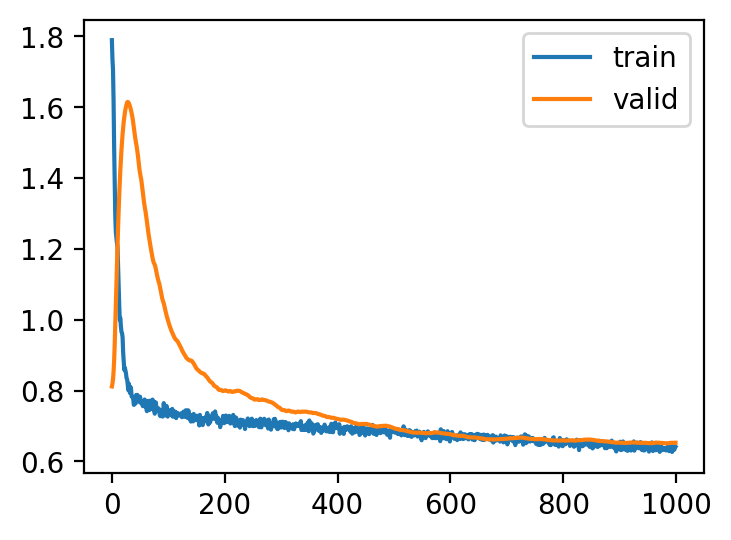

In [45]:
plt.figure(figsize=(4, 3), dpi=200)

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(trn_loss_history))
plt.plot(x, y, label='train')

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(val_loss_history))
plt.plot(x, y, label='valid')

plt.legend()
plt.show()